In [1]:
import pandas as pd 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation

In [42]:
sao_goncalo_data = pd.read_csv("data/data.csv")

sao_goncalo_data = sao_goncalo_data[sao_goncalo_data['Rio'] != 'lagoa dos patos']

sao_goncalo_data['ds'] = pd.to_datetime(sao_goncalo_data['ds'],format="mixed")

sao_goncalo_data['ds'] = sao_goncalo_data['ds'].dt.strftime("%d/%m/%Y %H:%M:%S")

In [43]:
sao_goncalo_data.tail()

,ds,Rio,y
81,05/12/2024 00:00:00,sao goncalo,2.77
82,05/12/2024 01:00:00,sao goncalo,2.78
83,05/12/2024 03:00:00,sao goncalo,2.78
84,05/12/2024 07:00:00,sao goncalo,2.80
85,05/12/2024 09:00:00,sao goncalo,2.80


In [44]:
pos_wind = pd.read_csv("data/wind_2.csv")

pos_wind['ds'] = pd.to_datetime(pos_wind['ds'], format="mixed")

pos_wind['ds'] = pos_wind['ds'].dt.strftime("%d/%m/%Y %H:%M:%S")

sao_goncalo_data = pd.merge(sao_goncalo_data, pos_wind, on="ds")

In [45]:
sao_goncalo_data.tail()

,ds,Rio,y,pos_wind
54,05/12/2024 00:00:00,sao goncalo,2.77,110
55,05/12/2024 01:00:00,sao goncalo,2.78,133
56,05/12/2024 03:00:00,sao goncalo,2.78,123
57,05/12/2024 07:00:00,sao goncalo,2.80,84
58,05/12/2024 09:00:00,sao goncalo,2.80,96


10:57:54 - cmdstanpy - INFO - Chain [1] start processing
10:57:54 - cmdstanpy - INFO - Chain [1] done processing


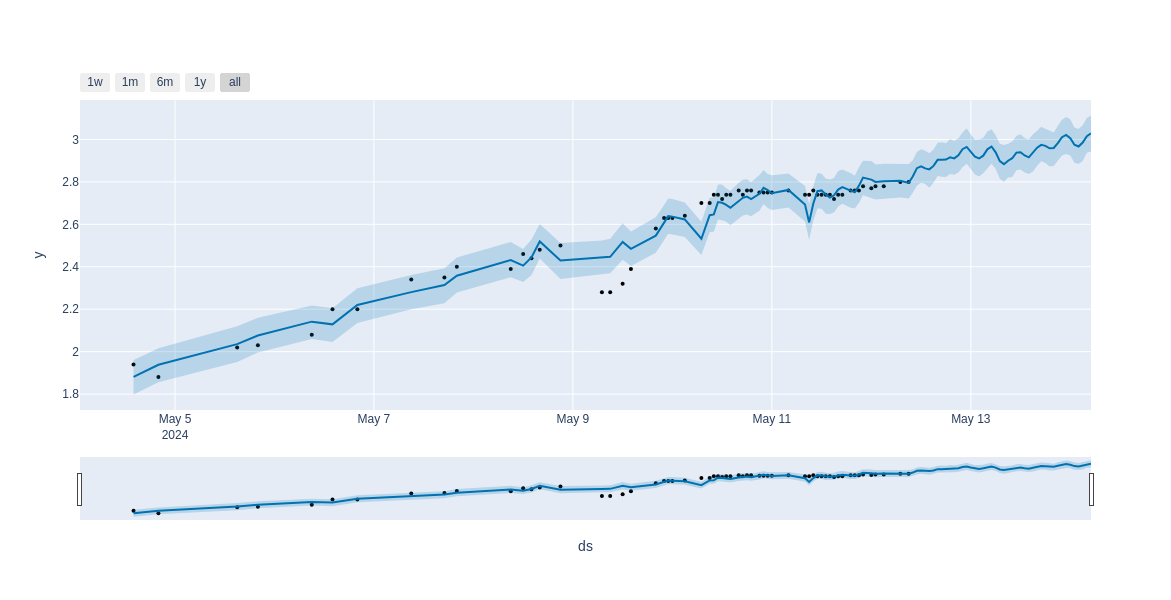

In [94]:
m = Prophet(
    yearly_seasonality=False,  
    weekly_seasonality=False,  
    daily_seasonality=True,    
    changepoint_range=0.8,     
    changepoint_prior_scale=0.75,
    changepoints=['2024-05-09 04:00:00'],
    growth="linear"         
)

# Defina os pontos de mudança
m.add_seasonality(name='daily', period=1, fourier_order=9, prior_scale = 0.01)
m.add_regressor("pos_wind", mode = "multiplicative", prior_scale = 0.8)

# Ajuste o modelo
m.fit(sao_goncalo_data)

# Realize previsões
future = m.make_future_dataframe(periods=44, freq='h')  

future['pos_wind'] = pos_wind['pos_wind']

forecast = m.predict(future)

# Visualize o resultado do modelo
plot_plotly(m, forecast)

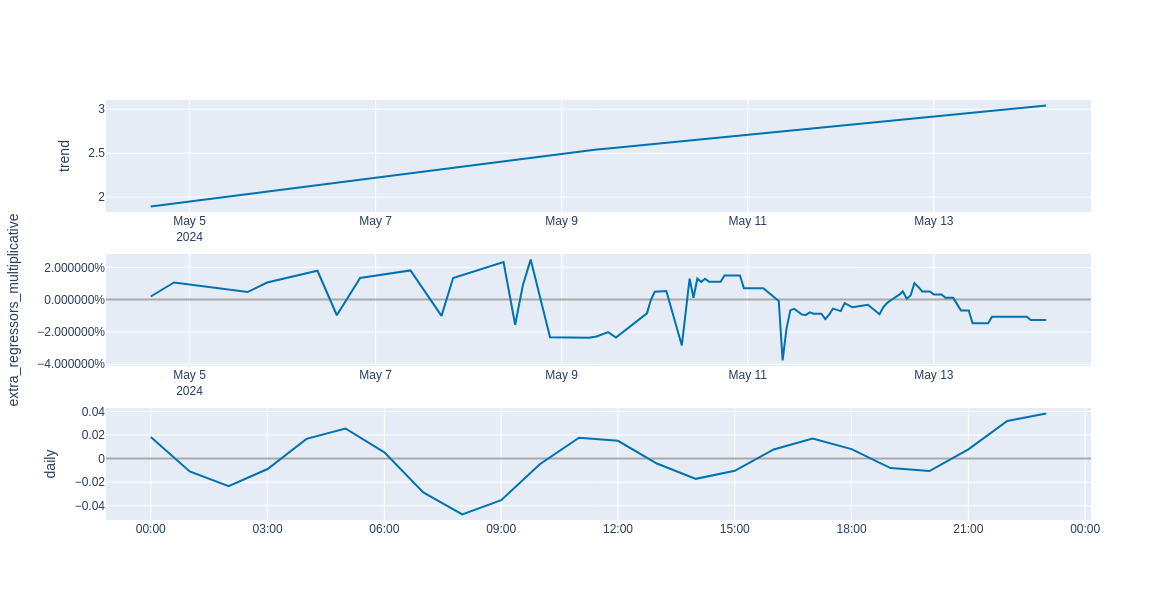

In [84]:
plot_components_plotly(m, forecast)

In [95]:
df_cv = cross_validation(m, initial='2 hour', period='15 hour', horizon = '6 hour')
df_cv.head()

Seasonality has period of 1 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/9 [00:00<?, ?it/s]

10:58:51 - cmdstanpy - INFO - Chain [1] start processing
10:58:54 - cmdstanpy - INFO - Chain [1] done processing
10:58:54 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-05-05 15:00:00,7.152177,7.152177,7.152177,2.02,2024-05-05 14:00:00
1,2024-05-05 20:00:00,7.042718,7.042718,7.042718,2.03,2024-05-05 14:00:00
2,2024-05-06 20:00:00,2.192736,2.192736,2.192736,2.20,2024-05-06 14:00:00
3,2024-05-07 17:00:00,-1.096771,-1.105286,-1.088183,2.35,2024-05-07 14:00:00
4,2024-05-07 20:00:00,2.399628,2.391305,2.407722,2.40,2024-05-07 14:00:00


In [96]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:00:00,5.305526,2.303373,1.146854,0.552710,0.033730,0.270831,0.400000
1,0 days 02:00:00,0.006086,0.078011,0.075926,0.027672,0.027672,0.027273,0.500000
2,0 days 03:00:00,2.993321,1.730122,0.983405,0.411495,0.070359,0.545964,0.000000
3,0 days 04:00:00,0.020816,0.144279,0.134586,0.048910,0.043450,0.049433,0.333333
4,0 days 05:00:00,0.060130,0.245213,0.221025,0.083415,0.068684,0.087540,0.000000


/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



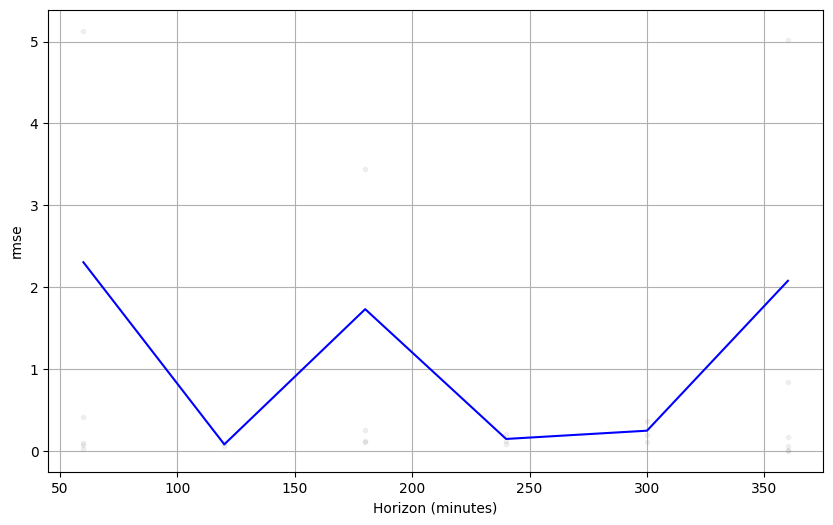

In [97]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [61]:
with open('data/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))